In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from utilities import *
import aiohttp
import time
import requests, os, time, random
from News.ip_rotator import ApiGateway
import creds
from binanceVision import BinanceDownloader
from bs4 import BeautifulSoup
import json

In [12]:
# Upbit
url = "https://api-manager.upbit.com"
endpoint = "/api/v1/announcements"
regions_list = ['us-east-1']

gateway = ApiGateway(url,regions=regions_list,access_key_id=creds.aws_key, access_key_secret=creds.aws_secret)
gateway.start()
session = requests.session()
session.mount("https://", gateway)

news_list = []
for page in np.arange(1,50):
    headers = {'origin': 'https://upbit.com'}
    params = {"os":"web","page":f"{page}","per_page":"20","category":"trade", '':f"{time.time()}"} # category: notice-안내, trade-거래, dtw-입출금
    response = session.get(url+endpoint, headers = headers, params = params)
    catalogs = response.json()['data']['notices']
    for news in catalogs:
        news_list.append({'exchange': 'upbit', 'title': news['title'],'date': pd.to_datetime(news['first_listed_at'],utc=True),'link': f"https://upbit.com/service_center/notice?id={news['id']}"})

Starting API gateway in 1 regions.
Using 1 endpoints with name 'https://api-manager.upbit.com - IP Rotate API' (0 new).


In [13]:
def delisting_upbit(news):
    if news['exchange'] == 'upbit':
        if "거래지원 종료 안내" in news['title']:
            pattern = r'\((\w+)\)'
            tickers = []
            part_before = re.split('거래지원 종료', news['title'])[0]
            tickers = re.findall(pattern, part_before)
            out = {'exchange': news['exchange'], 'tickers': tickers, 'date': news['date'], 'title': news['title']}
            return out
        
def listing_upbit(news):
    if news['exchange'] == 'upbit':
        if "신규 거래지원 안내" in news['title']:
            pattern = r'\((\w+)\)'
            tickers = []
            part_before = re.split('신규 거래지원 안내', news['title'])[0]
            tickers = re.findall(pattern, part_before)
            out = {'exchange': news['exchange'], 'tickers': tickers, 'date': news['date'],'title': news['title']}
            return out
        elif "원화마켓 신규 상장" in news['title']:
            # pattern = r'\((\w+)\)'
            pattern = r'\b[A-Z]+\b'
            tickers = re.findall(pattern, news['title'])
            tickers = [ticker for ticker in tickers if ticker not in ['USDT', 'KRW', 'BTC']]
            tickers = list(set(tickers))
            out = {'exchange': news['exchange'], 'tickers': tickers, 'date': news['date'],'title': news['title']}
            return out        
        
        elif ("디지털 자산 추가" in news['title']):
            # pattern = r'\((\w+)\)'
            pattern = r'\b[A-Z]+\b'
            tickers = re.findall(pattern, news['title'])
            tickers = [ticker for ticker in tickers if ticker not in ['USDT', 'KRW', 'BTC']]
            tickers = list(set(tickers))
            out = {'exchange': news['exchange'], 'tickers': tickers, 'date': news['date'], 'title': news['title']}
            return out                

In [14]:
event_list = [] 
btc_event_list = []
for news in news_list:
    event = listing_upbit(news)
    if event:
        if "KRW" in event['title']:
            event_list.append(event)

In [4]:
event_list

[]

In [25]:
'''  
Manually removed non-KRW Listings
'''

from pandas import Timestamp
krw_event_list =  [
{'exchange': 'upbit',
  'tickers': ['GAL'],
  'date': Timestamp('2024-07-11 02:22:28+0000', tz='UTC'),
  'hour_gap': 0.6,
  'title': '갤럭시(GAL) KRW 마켓 디지털 자산 추가'},
 {'exchange': 'upbit',
  'tickers': ['ENS'],
  'date': Timestamp('2024-07-09 08:40:30+0000', tz='UTC'),
  'hour_gap': 0.8,
  'title': '이더리움네임서비스(ENS) KRW 마켓 디지털 자산 추가'},
 {'exchange': 'upbit',
  'tickers': ['JUP'],
  'date': Timestamp('2024-07-04 06:42:18+0000', tz='UTC'),
  'hour_gap': 1.4,
  'title': '주피터(JUP) 신규 거래지원 안내 (KRW, BTC, USDT 마켓) (거래지원 개시 시점 연기 안내)'},
 {'exchange': 'upbit',
  'tickers': ['BLAST'],
  'date': Timestamp('2024-06-24 09:23:05+0000', tz='UTC'),
  'hour_gap': 5,
  'title': '블라스트(BLAST) 신규 거래지원 안내 (KRW, BTC, USDT 마켓) (매도 주문 제한 기준 가격 변경 안내)'},
 {'exchange': 'upbit',
  'tickers': ['ZRO'],
  'date': Timestamp('2024-06-20 06:02:42+0000', tz='UTC'),
  'hour_gap': 7,
  'title': '레이어제로(ZRO) 신규 거래지원 안내 (KRW, BTC, USDT 마켓) (거래지원 개시 시점 연기 안내)'},
 {'exchange': 'upbit',
  'tickers': ['ONDO'],
  'date': Timestamp('2024-06-14 03:06:53+0000', tz='UTC'),
  'hour_gap': 5,
  'title': '온도파이낸스(ONDO) 신규 거래지원 안내 (KRW, BTC, USDT 마켓)'},
 {'exchange': 'upbit',
  'tickers': ['TAIKO'],
  'date': Timestamp('2024-06-05 09:34:51+0000', tz='UTC'),
  'hour_gap': 20,
  'title': '타이코(TAIKO) 신규 거래지원 안내 (KRW, BTC, USDT 마켓) (거래지원 개시 시점 안내)'},
 {'exchange': 'upbit',
  'tickers': ['BEAM'],
  'date': Timestamp('2024-05-31 06:28:25+0000', tz='UTC'),
  'title': '빔(BEAM) 신규 거래지원 안내 (KRW, BTC, USDT 마켓) (거래지원 개시 시점 안내)'},
 {'exchange': 'upbit',
  'tickers': ['STG'],
  'date': Timestamp('2024-05-30 07:29:55+0000', tz='UTC'),
  'title': '스타게이트파이낸스(STG) KRW 마켓 디지털 자산 추가'},
 {'exchange': 'upbit',
  'tickers': ['AUCTION'],
  'date': Timestamp('2024-05-29 09:15:13+0000', tz='UTC'),
  'title': '바운스토큰(AUCTION) KRW 마켓 디지털 자산 추가'},
 {'exchange': 'upbit',
  'tickers': ['ZETA'],
  'date': Timestamp('2024-05-03 05:36:10+0000', tz='UTC'),
  'title': '제타체인(ZETA), 옴니네트워크(OMNI) 신규 거래지원 안내 (KRW, BTC, USDT 마켓)'},
 {'exchange': 'upbit',
  'tickers': ['AKT'],
  'date': Timestamp('2024-04-23 05:32:10+0000', tz='UTC'),
  'title': '빅타임(BIGTIME), 아카시네트워크(AKT) 신규 거래지원 안내 (KRW, BTC, USDT 마켓) (AKT 거래지원 개시 시점 연기 안내)'},
 {'exchange': 'upbit',
  'tickers': ['MNT'],
  'date': Timestamp('2024-03-27 05:13:24+0000', tz='UTC'),
  'title': 'KRW, BTC, USDT 마켓 디지털 자산 추가 (MNT, POKT) (POKT 거래지원 개시 시점 연기 안내)'},
 {'exchange': 'upbit',
  'tickers': [ 'PYTH'],
  'date': Timestamp('2024-02-27 02:45:08+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (ALT, PYTH)'},
 {'exchange': 'upbit',
  'tickers': ['ID'],
  'date': Timestamp('2024-02-07 04:13:10+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (ID)'},
 {'exchange': 'upbit',
  'tickers': ['ASTR'],
  'date': Timestamp('2023-12-18 07:30:00+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (ASTR) (거래지원 개시 시점 연기 안내)'},
 {'exchange': 'upbit',
  'tickers': ['CTC'],
  'date': Timestamp('2023-12-12 08:00:20+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (CTC)'},
 {'exchange': 'upbit',
  'tickers': ['MINA'],
  'date': Timestamp('2023-10-24 04:25:01+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (MINA)'},
 {'exchange': 'upbit',
  'tickers': ['SEI'],
  'date': Timestamp('2023-08-14 09:30:03+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (SEI) (매도 주문 제한 기준 가격 변경 안내)'},
 {'exchange': 'upbit',
  'tickers': ['IMX'],
  'date': Timestamp('2023-07-28 02:30:00+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (IMX)'},
 {'exchange': 'upbit',
  'tickers': ['BLUR'],
  'date': Timestamp('2023-06-27 05:00:00+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (BLUR)'},
 {'exchange': 'upbit',
  'tickers': ['GRT'],
  'date': Timestamp('2023-06-01 04:30:02+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (GRT)'},
 {'exchange': 'upbit',
  'tickers': ['SUI'],
  'date': Timestamp('2023-05-03 01:10:18+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (SUI) (매도 주문 제한 기준 가격 안내)'},
 {'exchange': 'upbit',
  'tickers': ['EGLD'],
  'date': Timestamp('2023-04-27 01:00:17+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (EGLD)'},
 {'exchange': 'upbit',
  'tickers': ['ARB'],
  'date': Timestamp('2023-03-30 01:00:00+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (ARB)'},
 {'exchange': 'upbit',
  'tickers': ['MASK', 'ACS'],
  'date': Timestamp('2023-03-07 00:30:08+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (MASK, ACS)'},
 {'exchange': 'upbit',
  'tickers': ['SHIB'],
  'date': Timestamp('2023-01-18 01:00:16+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (SHIB, GAL)'},
 {'exchange': 'upbit',
  'tickers': ['APT'],
  'date': Timestamp('2022-10-18 01:10:00+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (APT) (정상화 안내)'},
 {'exchange': 'upbit',
  'tickers': ['GMT'],
  'date': Timestamp('2022-05-04 01:00:01+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (GMT)'},
 {'exchange': 'upbit',
  'tickers': ['CELO'],
  'date': Timestamp('2022-03-17 02:00:01+0000', tz='UTC'),
  'title': 'KRW 마켓 디지털 자산 추가 (CELO)'},
 {'exchange': 'upbit',
  'tickers': ['NU', 'T'],
  'date': Timestamp('2022-03-02 03:30:02+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (T) 및 이에 따른 NU 유의 종목 지정 안내 (NU <> T 스왑 사이트 추가 안내)'},
 {'exchange': 'upbit',
  'tickers': ['AVAX'],
  'date': Timestamp('2022-02-08 04:00:23+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (AVAX, IMX) (거래지원 개시 시점 연장 안내)'},
 {'exchange': 'upbit',
  'tickers': ['WEMIX'],
  'date': Timestamp('2022-01-11 04:18:47+0000', tz='UTC'),
  'title': 'KRW, BTC 마켓 디지털 자산 추가 (WEMIX) (입금 지원 개시 안내)'},
]

In [26]:
event_list = krw_event_list

/Users/kennypark/anaconda3/envs/MLTrading/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


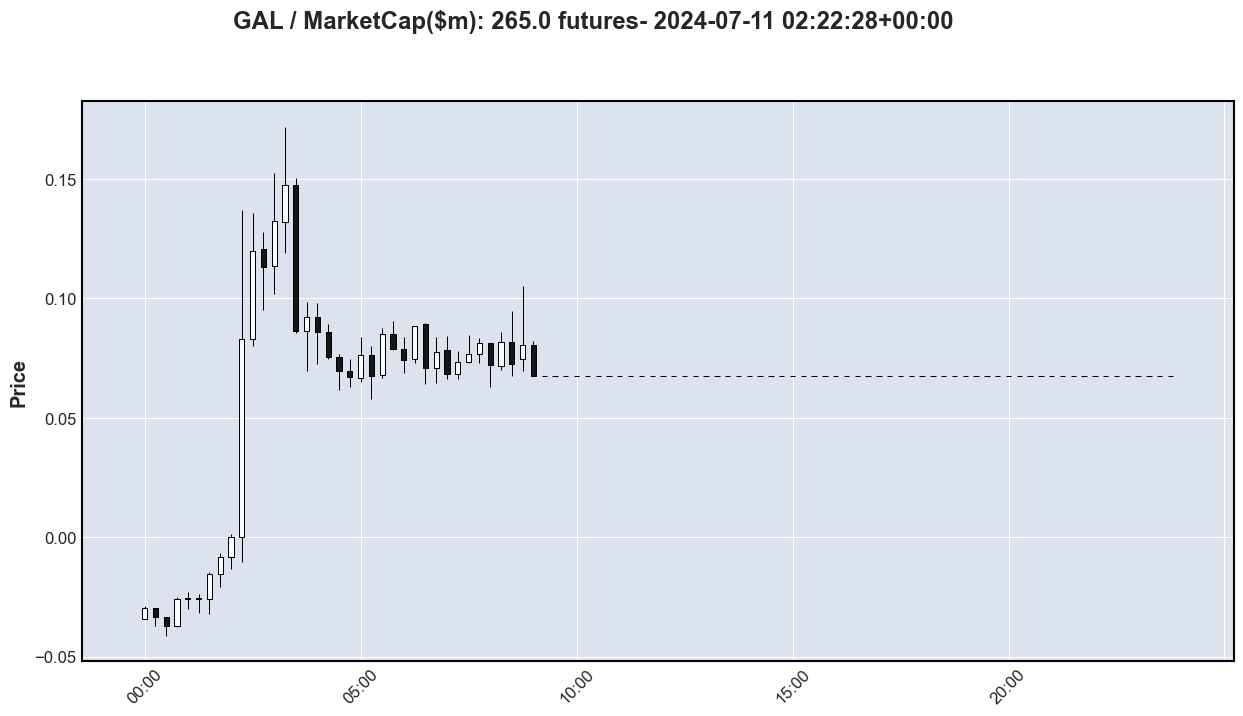

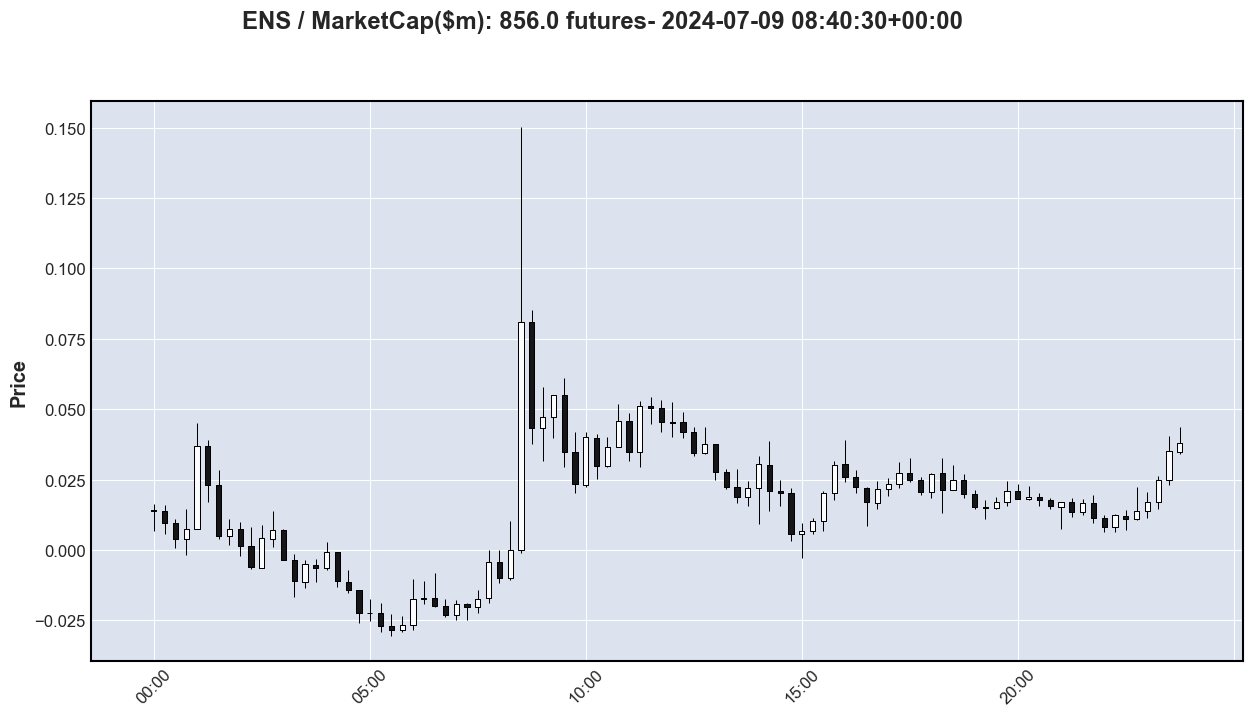

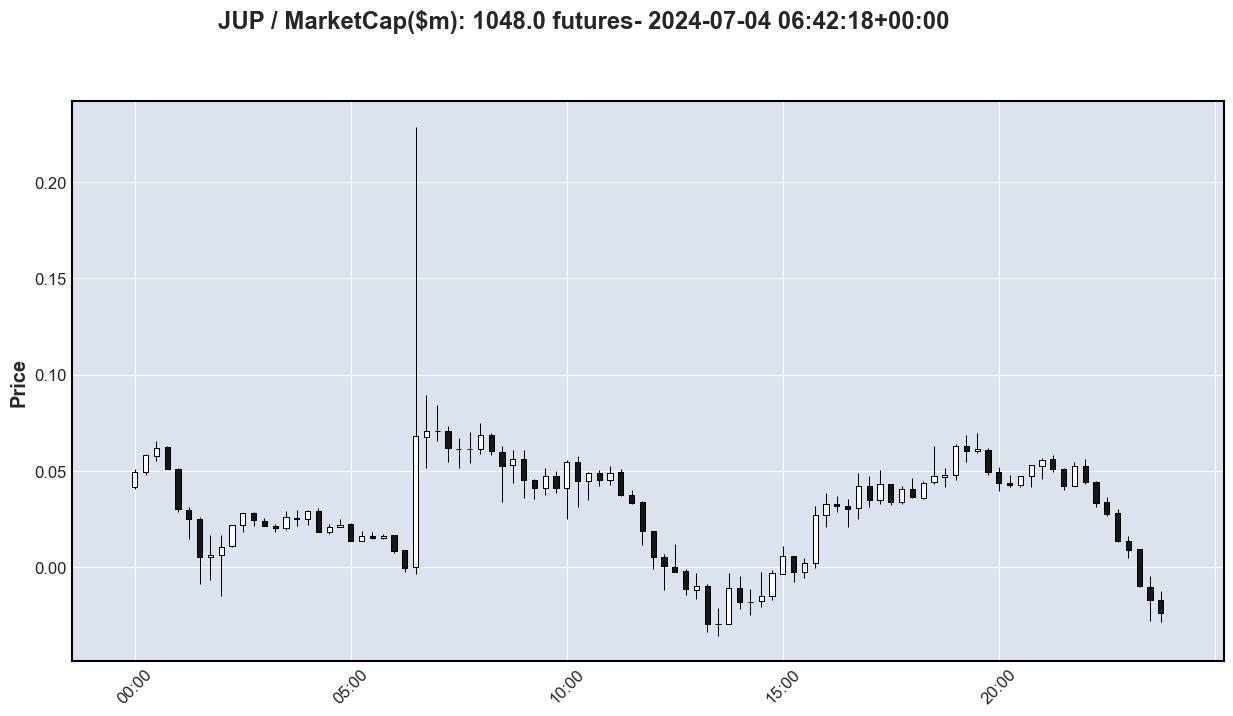

No cmc historical quotes fetched for ZRO


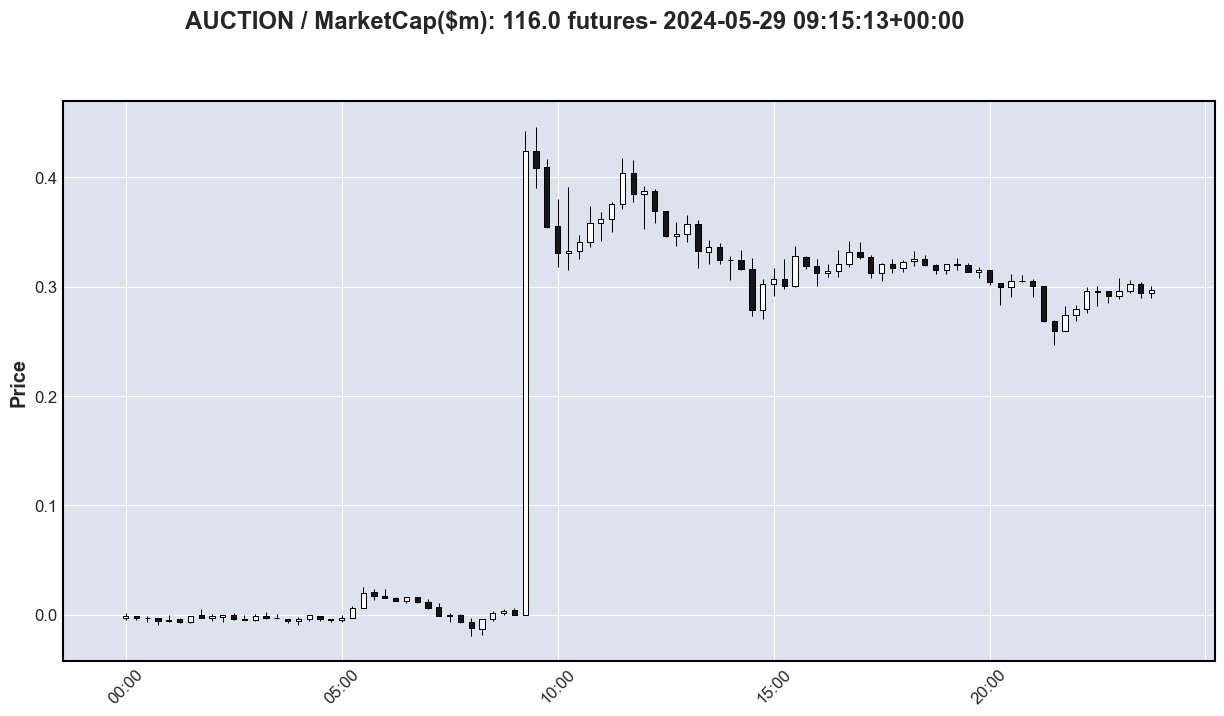

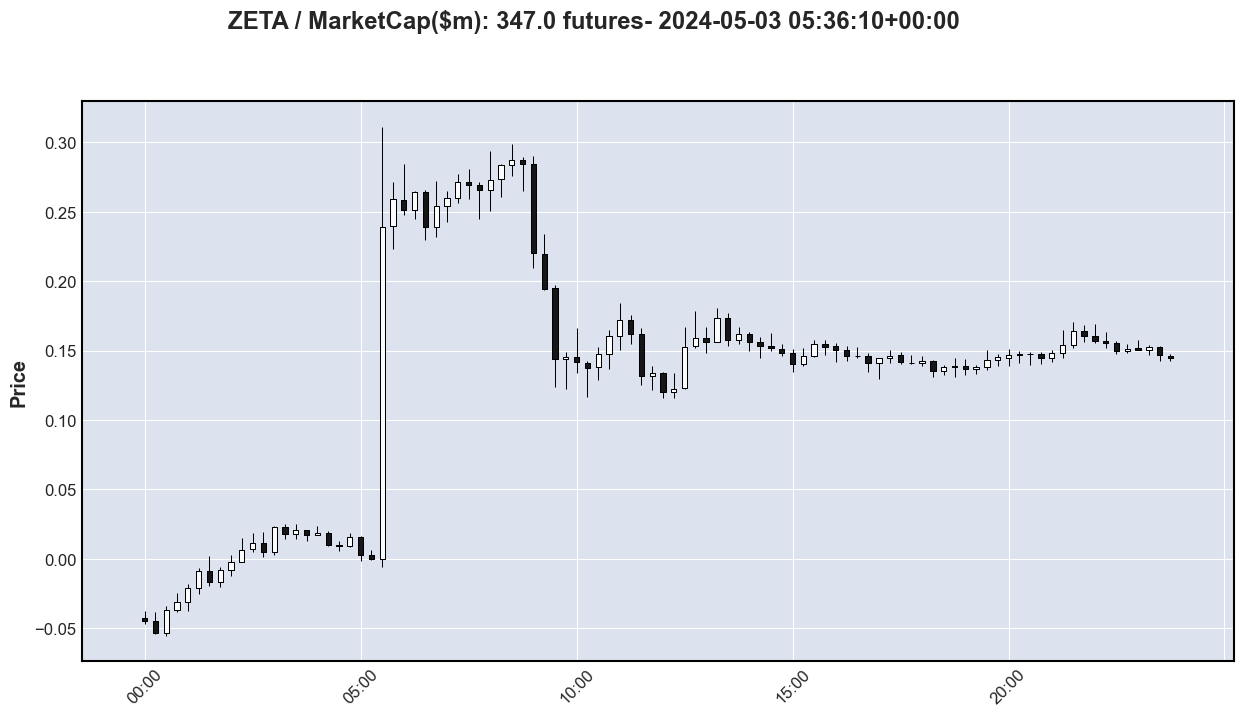

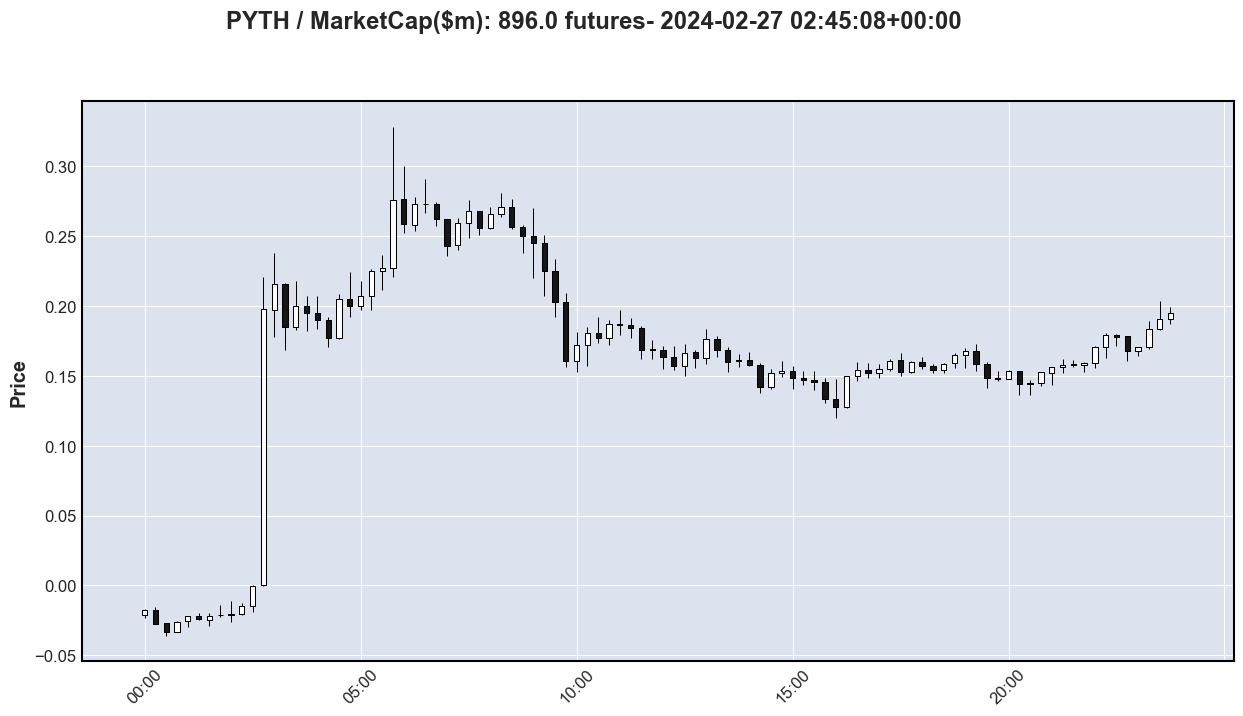

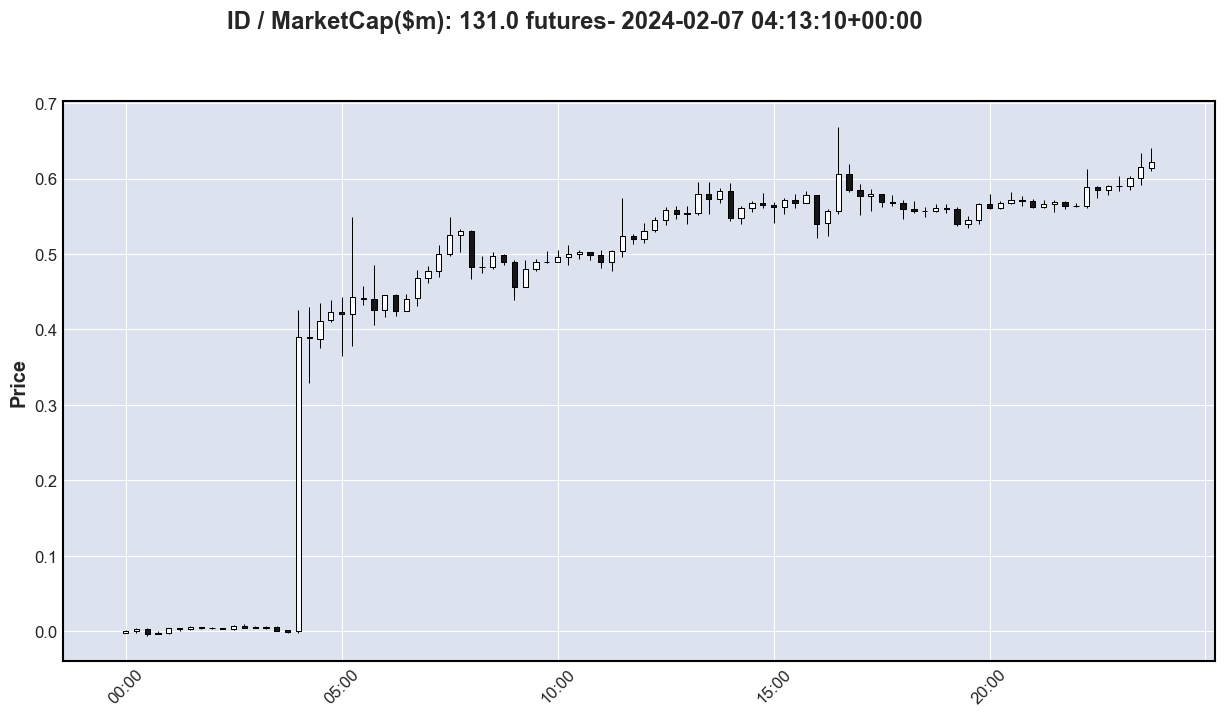

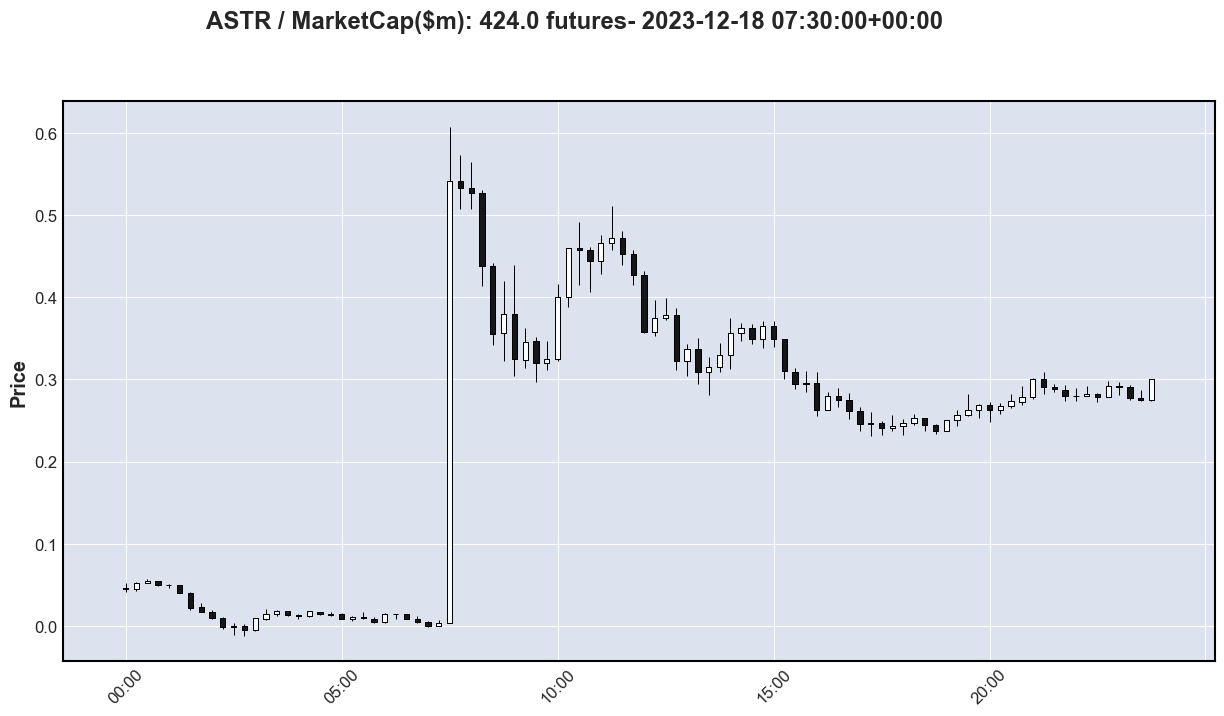

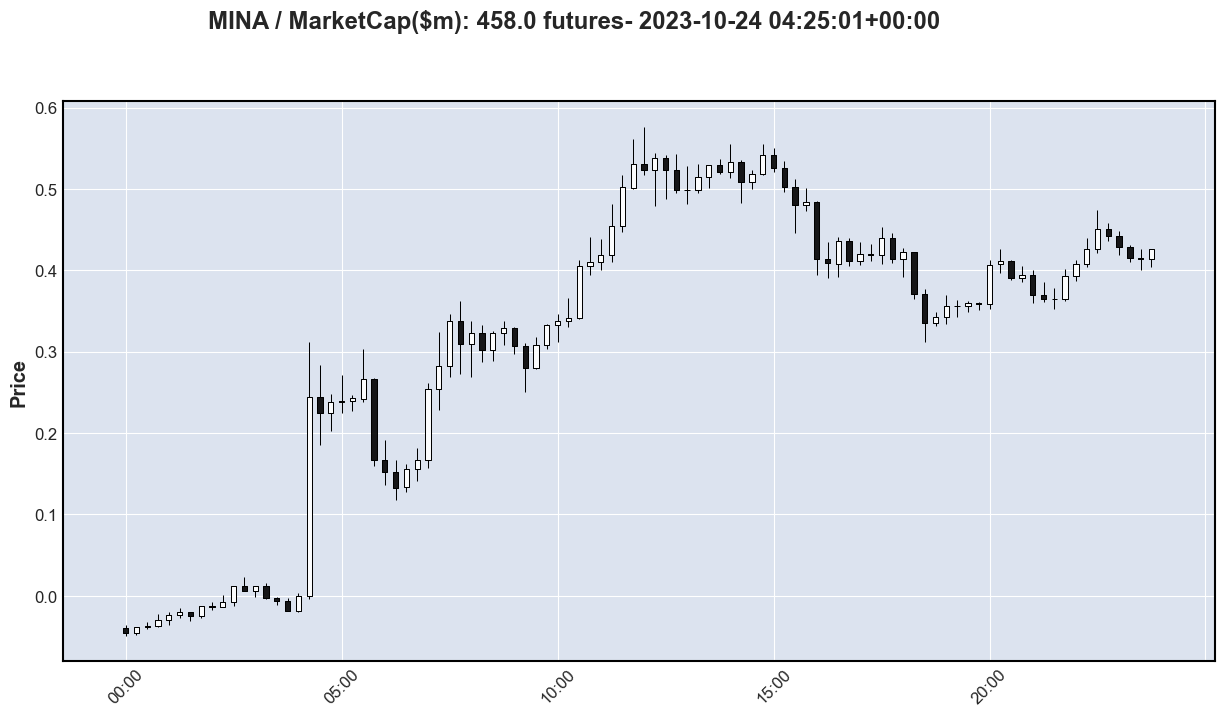

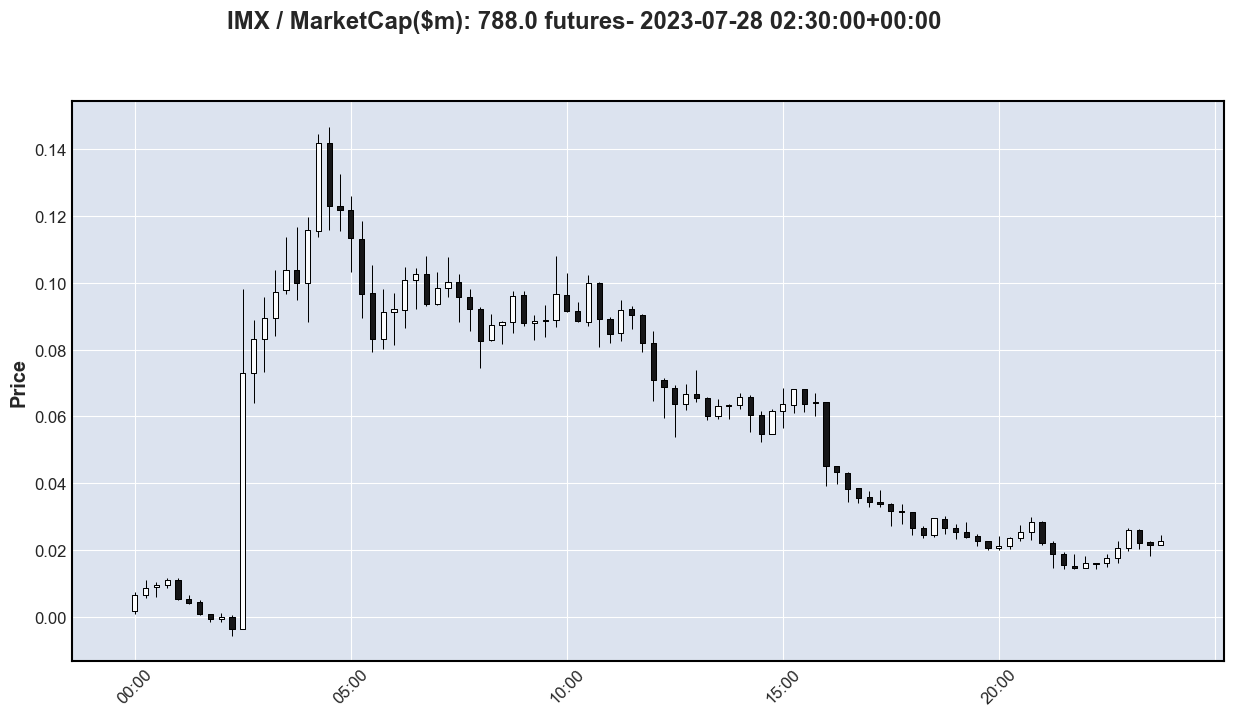

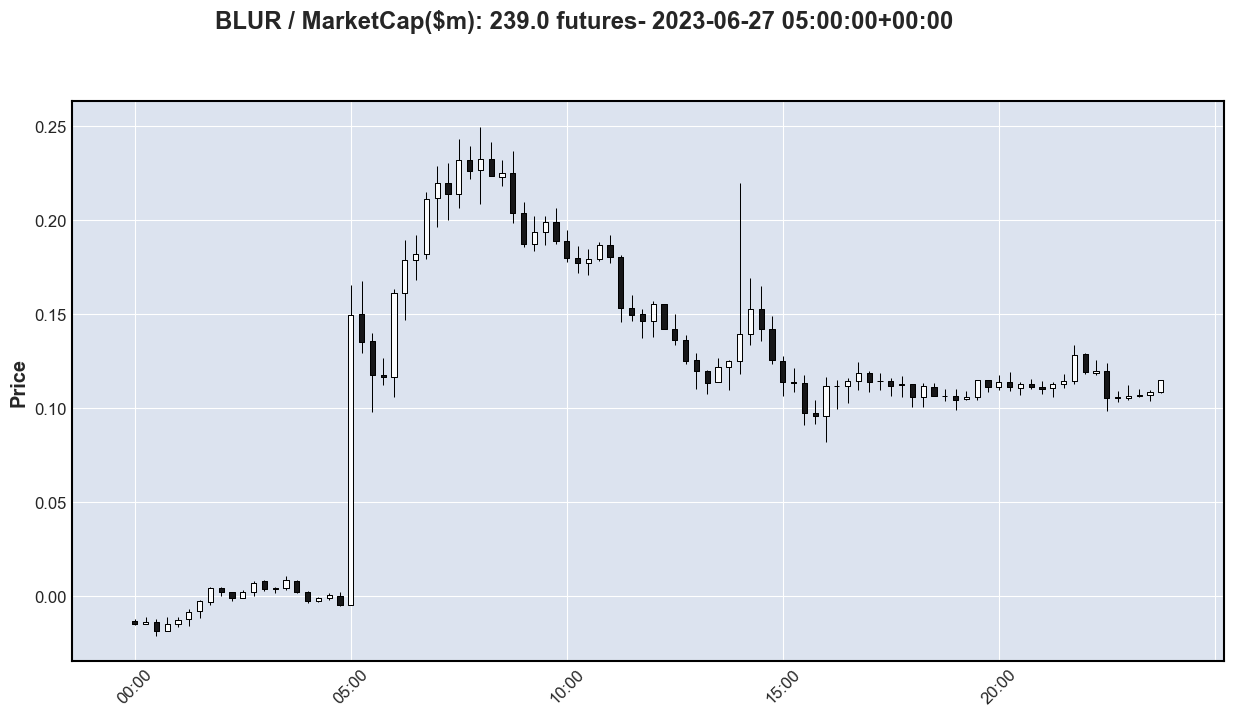

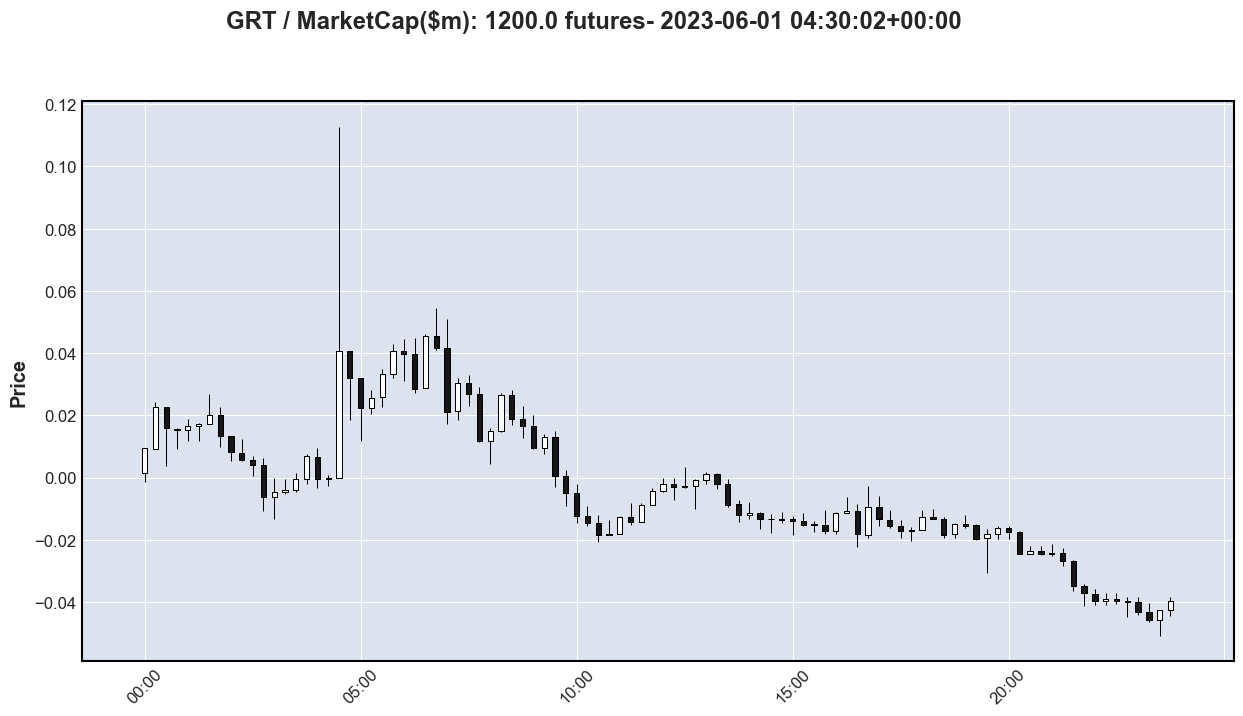

No cmc historical quotes fetched for SUI


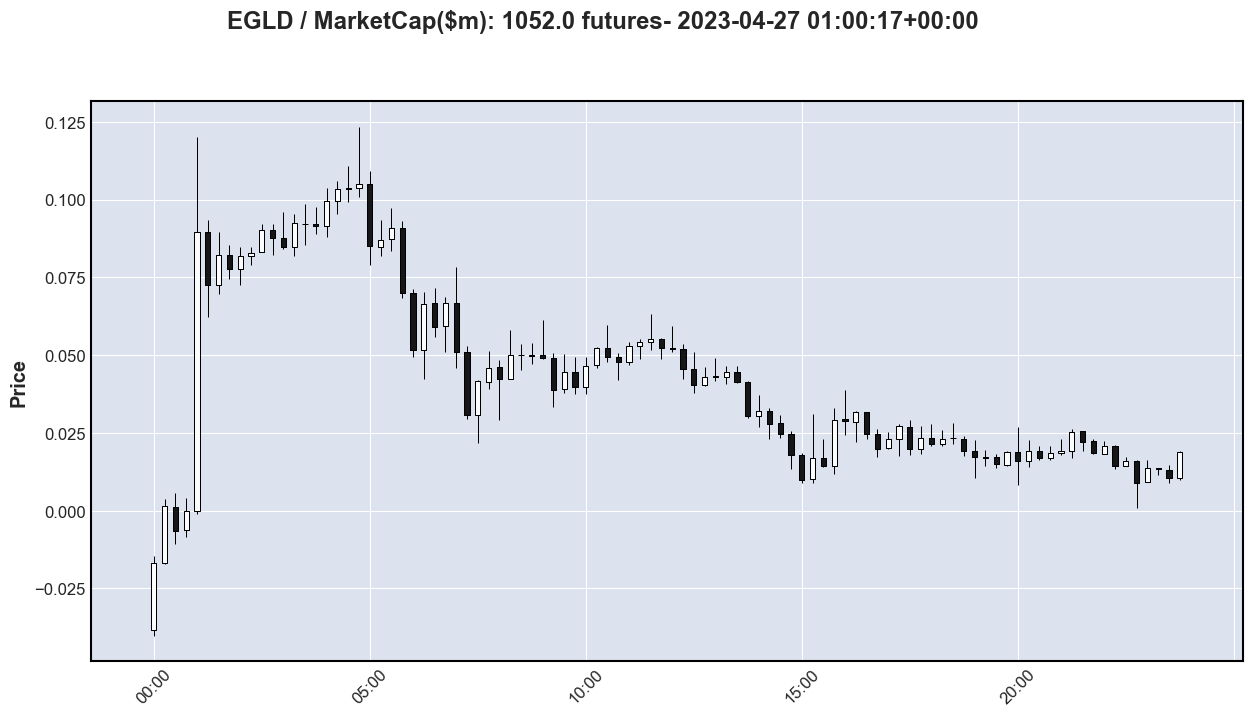

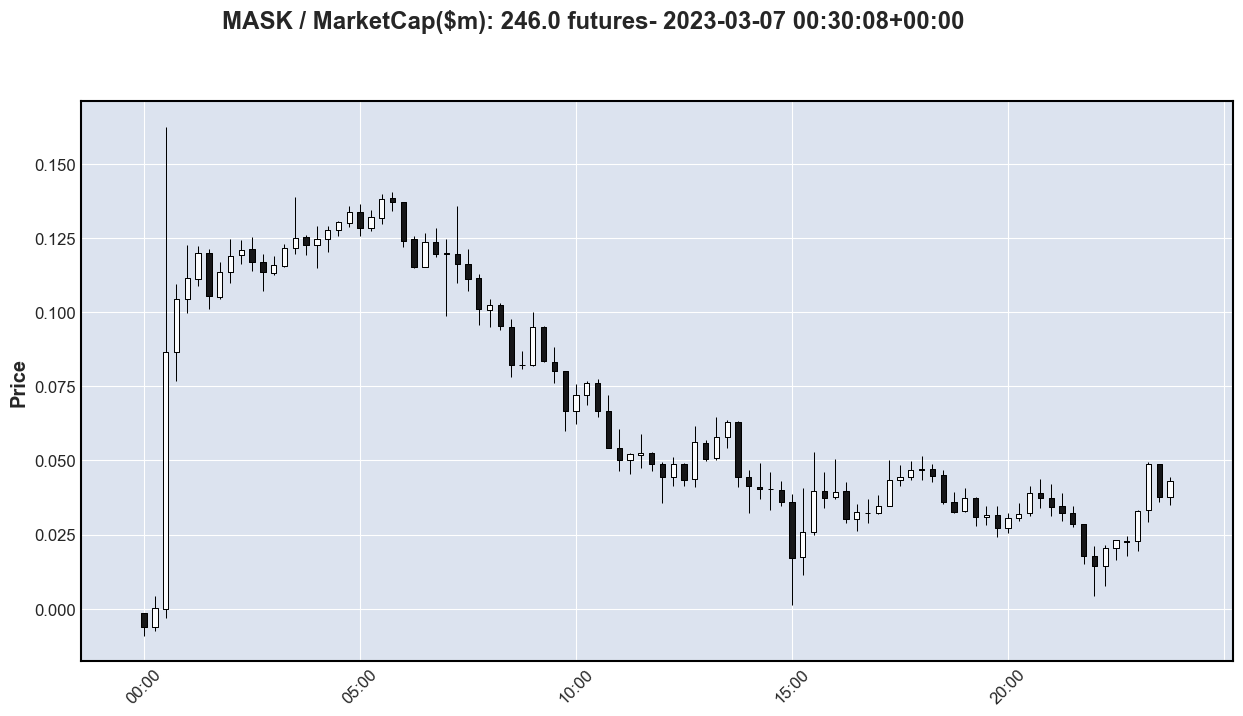

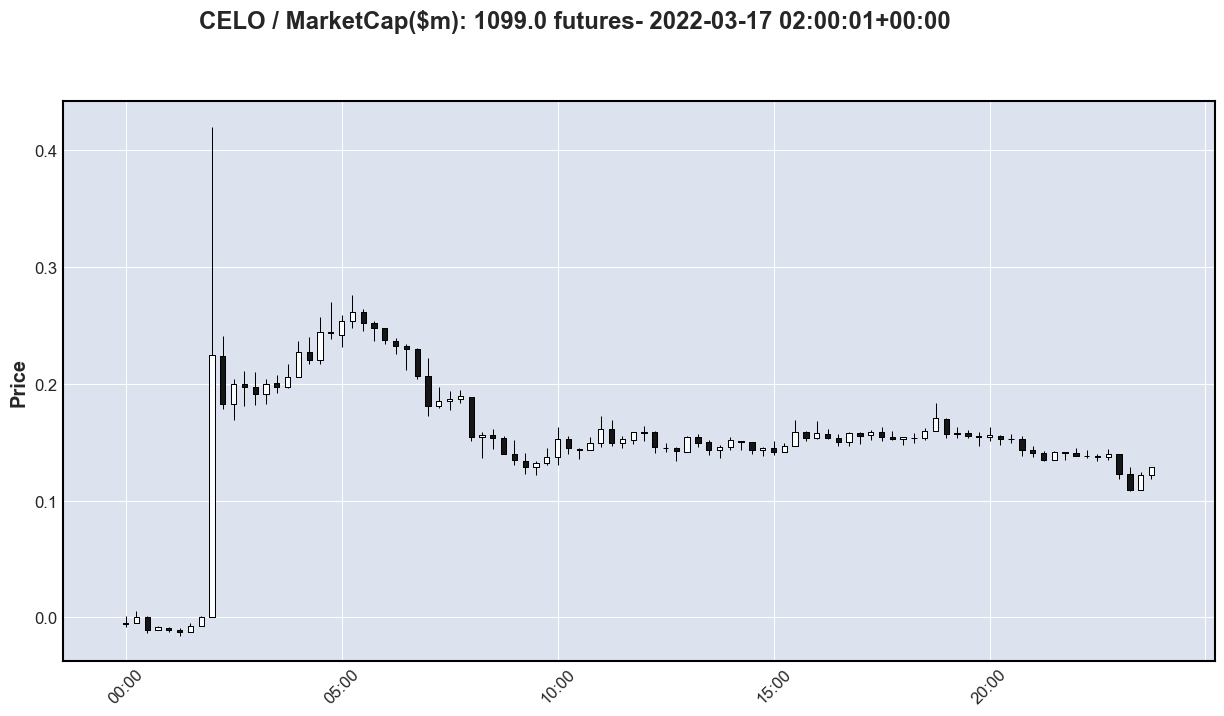

In [27]:
from binanceVision import BinanceDownloader
import mplfinance as mpf
from News.util import get_cmc_marketcap
bd = BinanceDownloader()
numDays = 1
tf = '15m'
marketcap_lower = 100
marketcap_upper = 1500

df_result = []
for event in event_list:
    time0 = event['date']
    for ticker in event['tickers']:
        asset_type = None
        result = {'ticker':ticker, 'date': time0,}
        
        try:
            # Data Retrieval
            symbol = (ticker+'USDT')
            df_ohlcv = pd.DataFrame()
            for n in np.arange(0,numDays):
                date = time0 + pd.Timedelta(days = n)
                df_ohlcv = pd.concat([df_ohlcv,bd.get_ohlcv_daily_(ticker = symbol, date = date.strftime("%Y-%m-%d"), timeframe = tf, type='futures')], axis=0)
                asset_type = 'futures'
        except:
            try:
                symbol = ("1000"+ticker+'USDT')
                df_ohlcv = pd.DataFrame()
                for n in np.arange(0,numDays):
                    date = time0 + pd.Timedelta(days = n)
                    df_ohlcv = pd.concat([df_ohlcv,bd.get_ohlcv_daily_(ticker = symbol, date = date.strftime("%Y-%m-%d"), timeframe = tf, type='futures')], axis=0)
                    asset_type = 'futures'                
            except:
                try:
                    continue
                    # symbol = (ticker+'USDT')
                    # df_ohlcv = pd.DataFrame()
                    # for n in np.arange(0,numDays):
                    #     date = time0 + pd.Timedelta(days = n)
                    #     df_ohlcv = pd.concat([df_ohlcv,bd.get_ohlcv_daily_(ticker = symbol, date = date.strftime("%Y-%m-%d"), timeframe = tf, type='spot')], axis=0)
                    #     asset_type = 'spot'                
                except:
                    continue


        df_ohlcv.Time = pd.to_datetime(df_ohlcv.Time, unit='ms', utc=True)
        df_ohlcv.set_index('Time', inplace=True)
        result['type'] = asset_type

        t0 = np.searchsorted(df_ohlcv.index, time0)
        t0 = df_ohlcv.index[t0 - 1]

        df_ohlcv = np.log(df_ohlcv) - np.log(df_ohlcv.Open[t0])

        marketcap = await get_cmc_marketcap(ticker, time0)

        if (marketcap is not None) and (marketcap > marketcap_lower) & (marketcap < marketcap_upper):
            marketcap = round(marketcap,0)
            try:
                # Configuration for the vertical line on the candlestick chart
                vlines = {
                    'vlines': [time0], 
                    'colors': ['y'], 
                    'linewidths': [1],
                    'linestyle':'-.',
                    'alpha': 0,
                }
                # Plot the candlestick chart with the vertical line on the same plot

                mpf.plot(df_ohlcv, type='candle', figsize=(16, 8), title=f"{ticker} / MarketCap($m): {marketcap} {asset_type}- {time0}", vlines=vlines)

                plt.show()
            except Exception as e:
                print(ticker, str(e))
                continue
            






In [ ]:
import binanceVision
bd = BinanceDownloader()
side = 'long'
df_result = []
for event in event_list:
    time0 = event['date']
    for ticker in event['tickers']:
        asset_type = None
        result = {'ticker':ticker, 'date': time0,}
        try:
            # Data Retrieval
            df_ohlcv = pd.DataFrame()
            
            for n in [0,1,2,3]:
                date = time0 + pd.Timedelta(days = n)
                try:
                    df_ohlcv = pd.concat([df_ohlcv,bd.get_ohlcv_daily_(ticker = (ticker+'USDT'), date = date.strftime("%Y-%m-%d"), timeframe = '1m', type='futures')], axis=0)
                    asset_type = 'futures'
                except:
                    df_ohlcv = pd.concat([df_ohlcv,bd.get_ohlcv_daily_(ticker = (ticker+'USDT'), date = date.strftime("%Y-%m-%d"), timeframe = '1m', type='spot')], axis=0)
                    asset_type = 'spot'
            df_ohlcv.Time = pd.to_datetime(df_ohlcv.Time, unit='ms', utc=True)
            df_ohlcv.set_index('Time', inplace=True)
            result['type'] = asset_type

            t0 = np.searchsorted(df_ohlcv.index, time0)
            t0 = df_ohlcv.index[t0-1]

            # Return Calculation
            for n_hours in [1, 3, 6, 12, 24, 48, 72]:
                t1 = t0 + pd.Timedelta(hours = n_hours)
                t1 = np.searchsorted(df_ohlcv.index, t1)
                t1 = df_ohlcv.index[t1]

                if side == 'short':
                    returns = 1 - df_ohlcv.Open[t1]/df_ohlcv.Open[t0]
                else:
                    returns = df_ohlcv.Open[t1]/df_ohlcv.Open[t0] - 1

                result[f'rets_{n_hours}h'] = returns


            # Volume Calculation
            if asset_type is not None:
                date = time0 - pd.DateOffset(months=1)
                if asset_type == 'futures':
                    df_ohlcv = bd.get_ohlcv_monthly_(ticker = (ticker+'USDT'), date = date.strftime("%Y-%m"), timeframe = '1d', type= 'futures')
                    avg_dollar_volume = (df_ohlcv.Volume*(df_ohlcv.Open+df_ohlcv.Close)/2).mean()
                    result['futures_volume'] = avg_dollar_volume
                
                df_ohlcv = bd.get_ohlcv_monthly_(ticker = (ticker+'USDT'), date = date.strftime("%Y-%m"), timeframe = '1d', type= 'spot')
                avg_dollar_volume = (df_ohlcv.Volume*(df_ohlcv.Open+df_ohlcv.Close)/2).mean()
                result['spot_volume'] = avg_dollar_volume

        except:
            pass

        df_result.append(result)
pd.DataFrame(df_result)


,ticker,date,type,rets_1h,rets_3h,rets_6h,rets_12h,rets_24h,rets_48h,rets_72h,futures_volume,spot_volume
0,JUP,2024-07-04 06:42:18+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BLAST,2024-06-24 09:23:05+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZRO,2024-06-20 06:02:42+00:00,futures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ONDO,2024-06-14 03:06:53+00:00,futures,0.054396,0.063986,0.054477,-0.033766,-0.033685,-0.030220,-0.086631,1.878198e+08,NaN
4,TAIKO,2024-06-05 09:34:51+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
56,SPND,2020-07-30 07:30:36+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,AHT,2020-07-27 07:20:35+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,HIVE,2020-07-21 07:10:45+00:00,spot,0.138122,0.095304,0.110958,0.084254,0.076427,0.040976,0.044199,NaN,734575.569752
59,DKA,2020-07-14 06:51:27+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_result = pd.DataFrame(df_result)

In [9]:
df_result = df_result[~pd.isna(df_result['type'])]

In [10]:
df_result

,ticker,date,type,rets_1h,rets_3h,rets_6h,rets_12h,rets_24h,rets_48h,rets_72h,futures_volume,spot_volume
2,ZRO,2024-06-20 06:02:42+00:00,futures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ONDO,2024-06-14 03:06:53+00:00,futures,0.054396,0.063986,0.054477,-0.033766,-0.033685,-0.030220,-0.086631,1.878198e+08,NaN
6,STG,2024-05-30 07:29:55+00:00,futures,0.468362,0.591191,0.569479,0.424524,0.418941,0.453267,0.480356,1.559261e+07,6.452921e+06
7,AUCTION,2024-05-29 09:15:13+00:00,futures,0.392295,0.472567,0.359442,0.350659,0.338874,0.324643,0.302518,2.624662e+07,8.446951e+06
9,ZETA,2024-05-03 05:36:10+00:00,futures,0.268531,0.332232,0.154411,0.158227,0.146118,0.218846,0.350139,2.599403e+07,NaN
10,OMNI,2024-05-03 05:36:10+00:00,futures,0.093750,0.081689,0.027961,0.050987,0.065789,0.020285,0.054276,1.535798e+08,4.652337e+07
11,BIGTIME,2024-04-23 05:32:10+00:00,futures,0.250251,0.153460,0.073721,0.092778,0.075226,-0.022066,0.028586,1.117940e+08,NaN
15,PYTH,2024-02-27 02:45:08+00:00,futures,0.221227,0.255390,0.292869,0.164179,0.143118,0.092869,0.094693,7.770347e+07,NaN
16,ALT,2024-02-27 02:45:08+00:00,futures,0.119166,0.110697,0.081802,0.041170,0.055159,-0.026723,-0.043083,5.544117e+08,1.917857e+08
17,ID,2024-02-07 04:13:10+00:00,futures,0.526484,0.608247,0.642375,0.711696,0.827586,1.210807,1.291148,2.650580e+07,9.974635e+06


In [6]:
# Ticker

import binanceVision


bd = BinanceDownloader()
side = 'long'
df_result = []
for event in event_list:
    time0 = event['date']
    for ticker in event['tickers']:
        asset_type = None
        result = {'ticker':ticker, 'date': time0,}
        try:
            # Data Retrieval
            date = time0
            try:
                df_trades = bd.get_trades_(ticker = (ticker+'USDT'),date = date.strftime("%Y-%m-%d"), aggTrades = True, freq='daily', type = 'futures')
                asset_type = 'futures'
            except:
                try:
                    df_trades = bd.get_trades_(ticker = (ticker+'USDT'),date = date.strftime("%Y-%m-%d"), aggTrades = True, freq='daily', type = 'spot')
                    asset_type = 'spot'
                except:
                    continue
            df_trades.transact_time = pd.to_datetime(df_trades.transact_time, unit='ms', utc=True)
            df_trades.set_index('transact_time', inplace=True)
            result['type'] = asset_type

            t0 = np.searchsorted(df_trades.index, time0)
            t0 = df_trades.index[t0-1]
            start_price = df_trades.price[t0]
            if not isinstance(start_price, float):
                start_price = start_price.iloc[-1]

            # Return Calculation
            for n_seconds in [5, 10, 30, 60, 60*2, 60*5]:
                t1 = t0 + pd.Timedelta(seconds = n_seconds)
                t1 = np.searchsorted(df_trades.index, t1)
                t1 = df_trades.index[t1]
                
                end_price = df_trades.price[t1]

                if not isinstance(end_price, float):
                    end_price = end_price.iloc[-1]    

                if side == 'short':
                    returns = 1 -  end_price / start_price
                else:
                    returns = end_price / start_price - 1

                result[f'rets_{n_seconds}s'] = returns                

            # # Volume Calculation
            # if asset_type is not None:
            #     date = time0 - pd.DateOffset(months=1)
            #     if asset_type == 'futures':
            #         df_ohlcv = bd.get_ohlcv_monthly_(ticker = (ticker+'USDT'), date = date.strftime("%Y-%m"), timeframe = '1d', type= 'futures')
            #         avg_dollar_volume = (df_ohlcv.Volume*(df_ohlcv.Open+df_ohlcv.Close)/2).mean()
            #         result['futures_volume'] = avg_dollar_volume
                
            #     df_ohlcv = bd.get_ohlcv_monthly_(ticker = (ticker+'USDT'), date = date.strftime("%Y-%m"), timeframe = '1d', type= 'spot')
            #     avg_dollar_volume = (df_ohlcv.Volume*(df_ohlcv.Open+df_ohlcv.Close)/2).mean()
            #     result['spot_volume'] = avg_dollar_volume

        except:
            pass

        df_result.append(result)
pd.DataFrame(df_result)

,ticker,date,type,rets_5s,rets_10s,rets_30s,rets_60s,rets_120s,rets_300s
0,JUP,2024-07-04 06:42:18+00:00,futures,0.221377,0.147852,0.134641,0.093408,0.071924,0.063384
1,ZRO,2024-06-20 06:02:42+00:00,futures,NaN,NaN,NaN,NaN,NaN,NaN
2,ONDO,2024-06-14 03:06:53+00:00,futures,0.144043,0.140015,0.122533,0.100862,0.069604,0.074921
3,STG,2024-05-30 07:29:55+00:00,futures,0.000620,0.000620,0.000620,0.342639,0.398677,0.308106
4,AUCTION,2024-05-29 09:15:13+00:00,futures,0.310947,0.323233,0.387947,0.377106,0.453605,0.450826
5,ZETA,2024-05-03 05:36:10+00:00,futures,0.258811,0.202717,0.201248,0.331424,0.313069,0.251101
6,OMNI,2024-05-03 05:36:10+00:00,futures,0.147945,0.234521,0.294795,0.193973,0.143014,0.163836
7,BIGTIME,2024-04-23 05:32:10+00:00,futures,0.002005,0.004010,0.085714,0.233083,0.264160,0.293734
8,PYTH,2024-02-27 02:45:08+00:00,futures,0.074756,0.096304,0.113542,0.162108,0.188298,0.214984
9,ALT,2024-02-27 02:45:08+00:00,futures,0.073080,0.071366,0.134579,0.162706,0.121003,0.121322
